In [1]:
import cv2

In [17]:
class OpencvCompareImage(object):

    def __init__(self, image_1_path, image_2_path):
        self.minimum_commutative_image_diff = 0.03
        self.image_1_path = image_1_path
        self.image_2_path = image_2_path

    def compare_image(self):
        image_1 = cv2.imread(self.image_1_path, 0)
        image_2 = cv2.imread(self.image_2_path, 0)
        commutative_image_diff = self.get_image_difference(image_1, image_2)

        if commutative_image_diff < self.minimum_commutative_image_diff:
            print("Matched")
            return commutative_image_diff
        return 10000 #random failure value

    @staticmethod
    def get_image_difference(image_1, image_2):
        first_image_hist = cv2.calcHist([image_1], [0], None, [256], [0, 256])
        second_image_hist = cv2.calcHist([image_2], [0], None, [256], [0, 256])

        img_hist_diff = cv2.compareHist(first_image_hist, second_image_hist, cv2.HISTCMP_BHATTACHARYYA)
        img_template_probability_match = cv2.matchTemplate(first_image_hist, second_image_hist, cv2.TM_CCOEFF_NORMED)[0][0]
        img_template_diff = 1 - img_template_probability_match

        # taking only 10% of histogram diff, since it's less accurate than template method
        commutative_image_diff = (img_hist_diff / 10) + img_template_diff
        return commutative_image_diff

In [18]:
if __name__ == '__main__':
        compare_image = OpencvCompareImage("/home/adity/Desktop/projects/image_search/datasets/Test Data/Client1/['aussie aussome hair conditioner treatment volumizing treatment 250'].jpg", "/home/adity/Desktop/projects/image_search/datasets/Test Data/Client2/['Aussie Aussome Hair Conditioner Treatment Volumizing Treatment 250ml'].jpg")
        image_difference = compare_image.compare_image()
        print(image_difference)

Matched
0.0


## MSE and SSIM <br>

In [1]:
import imutils
import cv2
import numpy as np
from skimage.measure import compare_ssim

In [2]:
def calculateMse(imageA, imageB):
    sum_A = np.sum(imageA.astype("float")) / float(imageA.shape[0] * imageA.shape[1])
    sum_B = np.sum(imageB.astype("float")) / float(imageB.shape[0] * imageB.shape[1])
    print("Sum_A: {}, Sum_B: {}".format(sum_A, sum_B))
    
    err= np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    
    err /= float(imageA.shape[0] * imageA.shape[1])
    return err

In [3]:
def resize_images(image):
    dim = (250, 250)
    return cv2.resize(image, dim)

def imgToGray(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [13]:
imageA = cv2.imread("/home/adity/Desktop/projects/image_search/datasets/Test Data/Client1/['alberto balsam apple shampoo 350'].jpg")
imageB = cv2.imread("/home/adity/Desktop/projects/image_search/datasets/Test Data/Client2/['Alberto Balsam Juicy Green Apple Shampoo  350ml'].jpg")

In [14]:
imageA = resize_images(imageA)
imageB = resize_images(imageB)

In [19]:
from skimage.metrics import structural_similarity
(score, diff) = structural_similarity(imageA, imageB, full=True, multichannel=True)

In [20]:
score

0.7006860427046816

In [60]:
imageA = cv2.imread("/home/adity/Desktop/projects/image_search/datasets/Test Data/Client1/['aussie man keep it clean shampoo 300'].jpg", 0)
imageB = cv2.imread("/home/adity/Desktop/projects/image_search/datasets/Test Data/Client2/['Vo5 Give Me Conditioner 250ml'].jpg", 0)

In [61]:
import time

In [62]:
tic = time.time()
(score, diff) = compare_ssim(imageA, imageB, full=True)
mse = calculateMse(imageA, imageB)
toc = time.time()
print("For {} & {}, SSIM: {}, MSE: {}, Execution Time: {}".format("1", "2", score, mse, toc - tic))

Sum_A: 198.63644444444444, Sum_B: 191.16284444444443
For 1 & 2, SSIM: 0.15765882797661945, MSE: 5467.158311111111, Execution Time: 0.007734775543212891


/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  


In [39]:
########################################################################################
# Author: Ujash Joshi, University of Toronto, 2017                                     #
# Based on Octave implementation by: Benjamin Eltzner, 2014 <b.eltzner@gmx.de>         #
# Octave/Matlab normxcorr2 implementation in python 3.5                                #
# Details:                                                                             #
# Normalized cross-correlation. Similiar results upto 3 significant digits.            #
# https://github.com/Sabrewarrior/normxcorr2-python/master/norxcorr2.py                #
# http://lordsabre.blogspot.ca/2017/09/matlab-normxcorr2-implemented-in-python.html    #
########################################################################################

import numpy as np
from scipy.signal import fftconvolve


def normxcorr2(template, image, mode="full"):
    """
    Input arrays should be floating point numbers.
    :param template: N-D array, of template or filter you are using for cross-correlation.
    Must be less or equal dimensions to image.
    Length of each dimension must be less than length of image.
    :param image: N-D array
    :param mode: Options, "full", "valid", "same"
    full (Default): The output of fftconvolve is the full discrete linear convolution of the inputs. 
    Output size will be image size + 1/2 template size in each dimension.
    valid: The output consists only of those elements that do not rely on the zero-padding.
    same: The output is the same size as image, centered with respect to the ‘full’ output.
    :return: N-D array of same dimensions as image. Size depends on mode parameter.
    """

    # If this happens, it is probably a mistake
    if np.ndim(template) > np.ndim(image) or \
            len([i for i in range(np.ndim(template)) if template.shape[i] > image.shape[i]]) > 0:
        print("normxcorr2: TEMPLATE larger than IMG. Arguments may be swapped.")

    template = template - np.mean(template)
    image = image - np.mean(image)

    a1 = np.ones(template.shape)
    # Faster to flip up down and left right then use fftconvolve instead of scipy's correlate
    ar = np.flipud(np.fliplr(template))
    out = fftconvolve(image, ar.conj(), mode=mode)

    image = fftconvolve(np.square(image), a1, mode=mode) - \
            np.square(fftconvolve(image, a1, mode=mode)) / (np.prod(template.shape))

    # Remove small machine precision errors after subtraction
    image[np.where(image < 0)] = 0

    template = np.sum(np.square(template))
    out = out / np.sqrt(image * template)

    # Remove any divisions by 0 or very close to 0
    out[np.where(np.logical_not(np.isfinite(out)))] = 0

    return out


In [43]:
out = normxcorr2(imageA, imageB)
max(out)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

## Deep Learning

In [21]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
import numpy as np
import cv2
from PIL import Image

# See https://keras.io/api/applications/ for details

class FeatureExtractor:
    def __init__(self):
        base_model = VGG16(weights='imagenet')
        self.model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)

    def extract(self, img):
        """
        Extract a deep feature from an input image
        Args:
            img: from PIL.Image.open(path) or tensorflow.keras.preprocessing.image.load_img(path)
        Returns:
            feature (np.ndarray): deep feature with the shape=(4096, )
        """
        img = np.resize(img,(224, 224, 3))  # VGG must take a 224x224 img as an input
#         img = img.convert('RGB')  # Make sure img is color
        img = Image.fromarray(img, 'RGB')
        x = image.img_to_array(img)  # To np.array. Height x Width x Channel. dtype=float32
        x = np.expand_dims(x, axis=0)  # (H, W, C)->(1, H, W, C), where the first elem is the number of img
        x = preprocess_input(x)  # Subtracting avg values for each pixel
#         feature = self.model.predict(x)[0]  # (1, 4096) -> (4096, )
        feature = self.model.predict(x)
        return feature / np.linalg.norm(feature)  # Normalize

In [37]:
imageA = cv2.imread("/home/adity/Desktop/projects/image_search/datasets/Test Data/Client1/['aussie man keep it clean shampoo 300'].jpg", 0)
imageB = cv2.imread("/home/adity/Desktop/projects/image_search/datasets/Test Data/Client2/['John Frieda Frizz Ease Miracle Recovery Deep Conditioner 150ml'].jpg", 0)

In [38]:
fe = FeatureExtractor()

featureA = fe.extract(img=imageA)
featureB = fe.extract(img=imageB)

In [39]:
featureA.shape

(1, 4096)

In [40]:
dists = np.linalg.norm(featureA-featureB, axis=1)  # L2 distances to features
ids = np.argsort(dists)[:30]  # Top 30 results
# scores = [(dists[id], img_paths[id]) for id in ids]

In [41]:
print(dists)

[1.1798803]


## Feature matching (SIFT)

here1
here


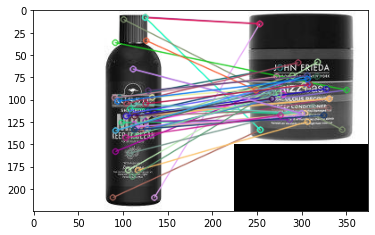

(<matplotlib.image.AxesImage at 0x7f56a374b198>, None)

In [3]:
import cv2 
import matplotlib.pyplot as plt
%matplotlib inline

# # read images
# img1 = cv2.imread('eiffel_2.jpeg')  
# img2 = cv2.imread('eiffel_1.jpg') 

img1 = cv2.imread("/home/adity/Desktop/projects/image_search/datasets/Test Data/Client1/['aussie man keep it clean shampoo 300'].jpg")
img2 = cv2.imread("/home/adity/Desktop/projects/image_search/datasets/Test Data/Client2/['John Frieda Frizz Ease Miracle Recovery Deep Conditioner 150ml'].jpg")

img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

print("here1")

# Initiate SIFT detector
sift = cv2.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

print("here")

# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.match(des1,des2)

matches = sorted(matches, key=lambda val: val.distance)

img3 = cv2.drawMatches(img1, kp1, img2, kp2, matches[:50], img2, flags=2)
plt.imshow(img3),plt.show()